In [1]:

#loading in dependencies, run this on greenlandMapping - future make new env
%load_ext autoreload
%autoreload 2
import os
import dask
import panel
import pandas as pd
import matplotlib.pyplot as plt
import nisardev as nisar
import grimpfunc as grimp
import matplotlib.pyplot as plt
import xarray as xr
import numpy as np
import geopandas as gpd
import glob
import shapely
from dask.diagnostics import ProgressBar
from shapely.ops import linemerge, unary_union
ProgressBar().register()
dask.config.set(num_workers=2)  # Avoid problems with too many open connections at NSIDC
panel.extension() 

In [2]:
#paths
centreline_path = "/Users/sofiasuhinin/Desktop/GrIS_Calving/flowlines/jacobshavn_centreline_ss.shp"
terminus_path = "/Users/sofiasuhinin/Desktop/GrIS_Calving/Jakobshavn-Isbrae-CalvingStatistics/data/MEaSUREs_0781/collated/JakbobshavnIsbraeTerminus.shp"
velocity_path = "/Users/sofiasuhinin/Desktop/GrIS_Calving/Jakobshavn-Isbrae-CalvingStatistics/data/MEaSUREs_0766/JakobshavnIsbraeVelocitySeriesNew.nc"
centreline_maqit_path = "/Users/sofiasuhinin/Desktop/GrIS_Calving/Jakobshavn-Isbrae-CalvingStatistics/centreline1.csv"

#read in velocity 
velocity = xr.open_dataset(velocity_path)

#read in centreline + make sure coordinate system = EPSG:3413
centreline = gpd.read_file(centreline_path)
centreline = centreline.to_crs("EPSG:3413")

# merge extended centreline into 1
c_merged = linemerge(unary_union(centreline.geometry))
centreline = gpd.GeoDataFrame(geometry=[c_merged], crs=centreline.crs)
centreline_shape = centreline.geometry.iloc[0]

#sanity check for geospatial alignment
print(centreline.crs)

#read in terminus
terminus = gpd.read_file(terminus_path)
terminus = terminus.to_crs("EPSG:3413")

#sanity check for geospatial alignment
print(terminus.crs)

terminus = terminus.rename(columns={"SourceDate": "Date"}) #rename for simplicity
terminus["Date"] = pd.to_datetime(terminus["Date"]) #make sure it is in datetime 
terminus = terminus.sort_values("Date").reset_index(drop=True) #sort in chronological 

EPSG:3413
EPSG:3413


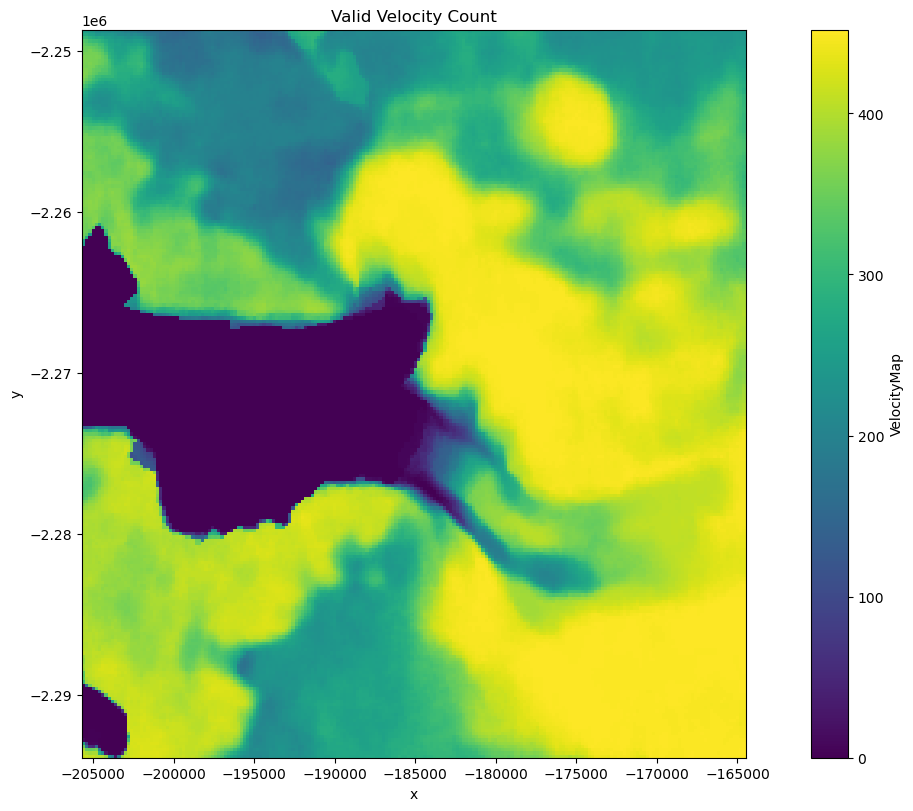

In [3]:
#preparing velocity data for plotting
x_vals = velocity["x"].values
y_vals = velocity["y"].values

vel_band = velocity["VelocityMap"].isel(band=2).assign_coords(
    x=("x", x_vals),
    y=("y", y_vals),
)
vel_times = pd.to_datetime(vel_band["time"].values)

valid_count = vel_band.count(dim="time")  #points with "valid" non NaN values

fig, ax = plt.subplots(1, figsize=(10, 8), constrained_layout=True)

#1: Valid Velocity Count 
valid_count.plot(
    ax=ax,
    x="x",
    y="y",
    add_colorbar=True,
)
ax.set_title("Valid Velocity Count")
ax.set_aspect("equal")


Ignoring fixed x limits to fulfill fixed data aspect with adjustable data limits.
Ignoring fixed x limits to fulfill fixed data aspect with adjustable data limits.


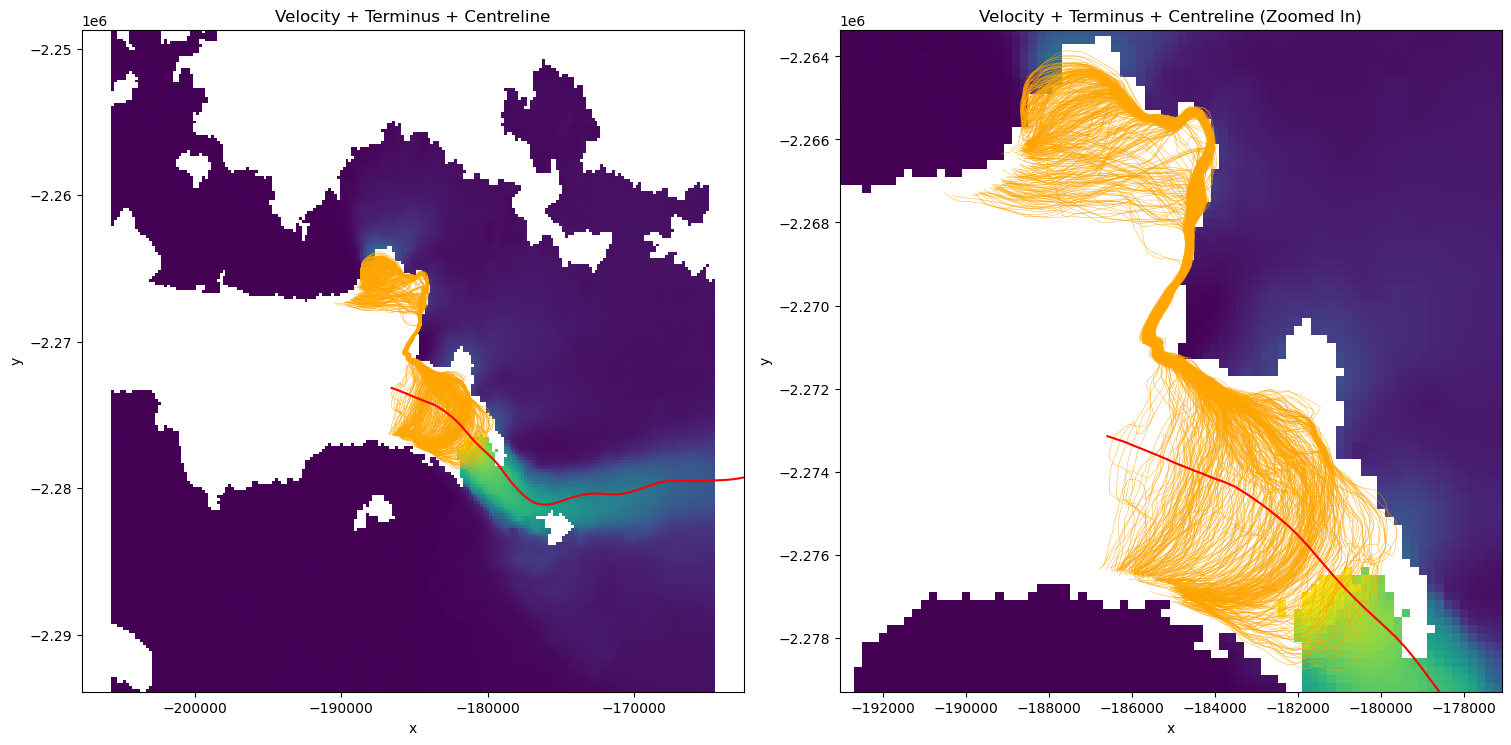

In [4]:
#preparing velocity data for plotting
x_vals = velocity["x"].values
y_vals = velocity["y"].values

vel_band = velocity["VelocityMap"].isel(band=2).assign_coords(
    x=("x", x_vals),
    y=("y", y_vals),
)
vel_times = pd.to_datetime(vel_band["time"].values)

valid_count = vel_band.count(dim="time")  #points with "valid" non NaN values

sampletime = 300
vel_slice = velocity["VelocityMap"].isel(band=2, time=sampletime)

#preparing centreline for plotting
centreline_gs = gpd.GeoSeries([centreline_shape], crs=terminus.crs)

fig, ax = plt.subplots(1, 2, figsize=(15, 15), constrained_layout=True)

#1: Velocity visual w centerline and terminus
vel_slice.plot(
    ax=ax[0],
    x="x",         
    y="y",         
    add_colorbar=False,
)

terminus.plot(
    ax=ax[0],
    facecolor="none",
    edgecolor="orange",
    linewidth=0.3,
)

centreline_gs.plot(
    ax=ax[0],
    color="red",
    linewidth=1.5,
)

ax[0].set_title("Velocity + Terminus + Centreline")

# 3. Zoomed in version of #2
vel_slice.plot(
    ax=ax[1],
    x="x",
    y="y",
    add_colorbar=False,
)

terminus.plot(
    ax=ax[1],
    facecolor="none",
    edgecolor="orange",
    linewidth=0.3,
)

centreline_gs.plot(
    ax=ax[1],
    color="red",
    linewidth=1.5,
)

# Zoom in on terminus area - DONT zoom on centerline because its HUGE
xmin, ymin, xmax, ymax = terminus.total_bounds
z00m = 500  

ax[1].set_xlim(xmin - z00m, xmax + z00m)
ax[1].set_ylim(ymin - z00m, ymax + z00m)

ax[1].set_title("Velocity + Terminus + Centreline (Zoomed In)") 

for a in ax:
    a.set_box_aspect(1)

plt.show()

velocity: 2017-09-25 12:00:00
terminus: 2017-09-25 00:00:00
velocity: 2020-10-21 12:00:00
terminus: 2020-10-21 00:00:00


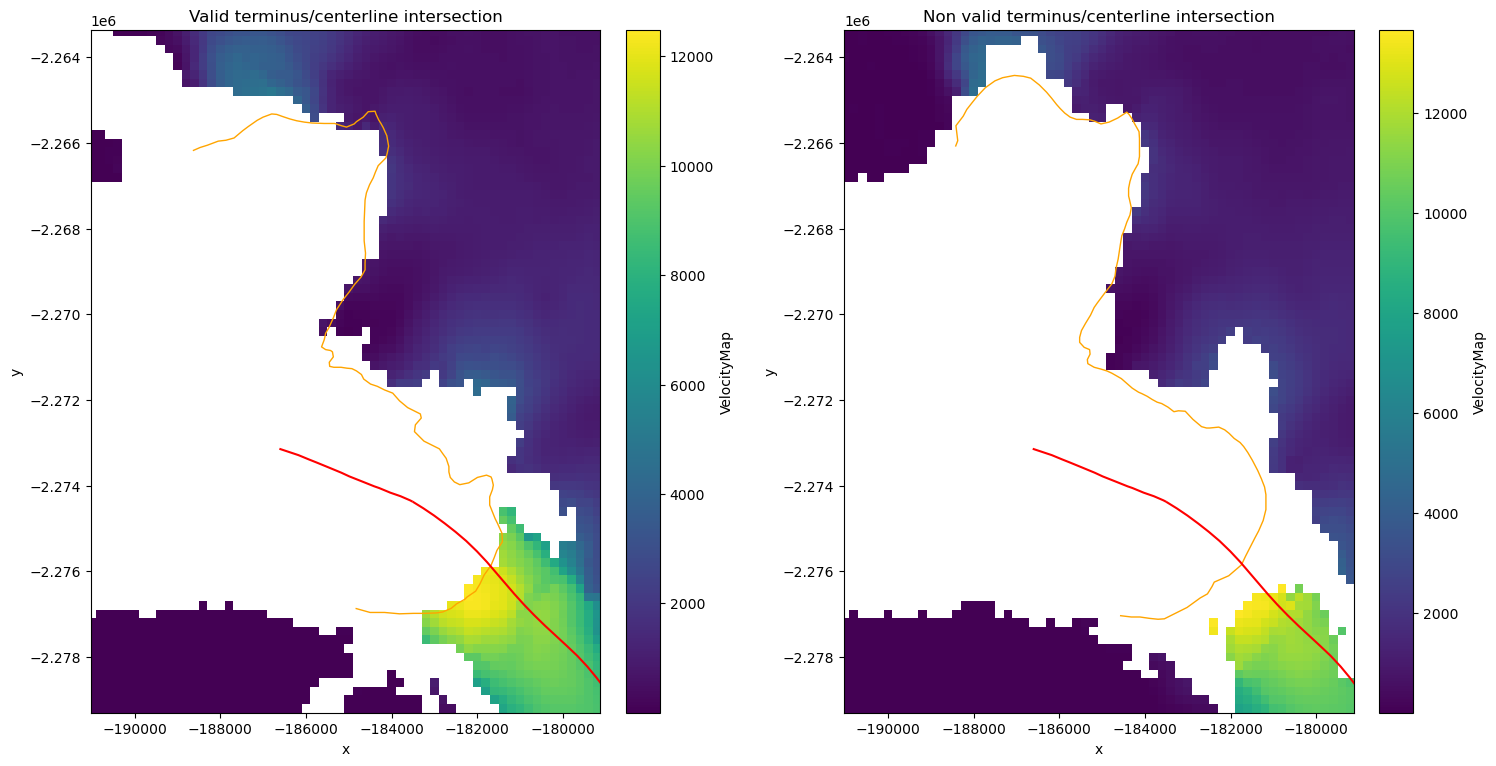

In [5]:
#visualising velocity, terminus and centerline on one with a VALID intersection value
    #velocity: 2017-10-01 12:00:00
    #terminus: 2017-10-01 00:00:00  
sampletime1 = 113

vel_time = velocity["time"].isel(time=sampletime1).values 
nearest_time = (terminus["Date"]- vel_time).abs().idxmin() #calc nearest terminus(Date) and vel time
term_time = terminus.loc[[nearest_time]] #this selects the terminus geometry from the nearest_time

vel_slice = velocity["VelocityMap"].isel(band=2, time=sampletime1)

#CHECK:are these the same day/near?
t_vel = pd.to_datetime(vel_time)
t_term = term_time["Date"].iloc[0]
print("velocity:", t_vel)
print("terminus:", t_term)

vel_slice = vel_slice.assign_coords(
    x=("x", x_vals),
    y=("y", y_vals),
)
nrow, ncol = (1, 2)

fig, ax = plt.subplots(
    figsize=(15, 15),
    layout ='compressed',
    nrows = nrow, 
    ncols = ncol,
) 

vel_slice.plot(
    ax=ax[0],
    x="x",         
    y="y",         
    add_colorbar=True,
)

term_time.plot(
    ax=ax[0],
    facecolor="none",
    edgecolor="orange",
    linewidth=1,
)

centreline_gs = gpd.GeoSeries([centreline_shape], crs=terminus.crs if hasattr(terminus, "crs") else None)
centreline_gs.plot(
    ax=ax[0],
    color="red",
    linewidth=1.5,
)

#visualising velocity, terminus and centerline on one with a NON VALID intersection value
sampletime2 = 300

vel_time = velocity["time"].isel(time=sampletime2).values 
nearest_time = (terminus["Date"]- vel_time).abs().idxmin() #calc nearest terminus(Date) and vel time
term_time = terminus.loc[[nearest_time]] #this selects the terminus geometry from the nearest_time

vel_slice = velocity["VelocityMap"].isel(band=2, time=sampletime2)

#CHECK:are these the same day/near?
t_vel = pd.to_datetime(vel_time)
t_term = term_time["Date"].iloc[0]
print("velocity:", t_vel)
print("terminus:", t_term)

vel_slice = vel_slice.assign_coords(
    x=("x", x_vals),
    y=("y", y_vals),
)

vel_slice.plot(
    ax=ax[1],
    x="x",         
    y="y",         
    add_colorbar=True,
)

term_time.plot(
    ax=ax[1],
    facecolor="none",
    edgecolor="orange",
    linewidth=1,
)

centreline_gs = gpd.GeoSeries([centreline_shape], crs=terminus.crs if hasattr(terminus, "crs") else None)
centreline_gs.plot(
    ax=ax[1],
    color="red",
    linewidth=1.5,
)

#zoom in order to see insct. better
xmin, ymin, xmax, ymax = terminus.total_bounds

z00m = 500  

for a in ax:
    a.set_xlim(xmin - z00m, xmax + z00m)
    a.set_ylim(ymin - z00m, ymax + z00m)

ax[0].set_title("Valid terminus/centerline intersection")
ax[1].set_title("Non valid terminus/centerline intersection")

plt.tight_layout
plt.show()

### Step 1: Velocity value from the centreline and terminus intersection

In [6]:
# finding the intersection between the centerline and the terminus
def intersection(centreline, terminus_line):
    intersect = centreline.intersection(terminus_line)

    if intersect.is_empty:
        return None
    
    if intersect.geom_type == "MultiPoint": #if there is more than one intersect put the point closes to the centre of the terminus line
        return min(intersect.geoms, key = lambda p: p.distance(terminus_line.centroid))
    
    return intersect
 
pts = []
for i in range(len(terminus)):
    terminus_line = terminus.geometry.iloc[i]
    pt = intersection(centreline_shape, terminus_line) #geometric intersection between centerline_shape and terminus_line 
    pts.append(pt)

terminus["intersect_points"] = pts

#check to see how many are NaN (i.e. no valid intersection)
none_vals = terminus["intersect_points"].isna().sum()
print(f"Number of NaN intersection points: {none_vals}")

#check to see how many as non NaN (i.e. valid intersection)
valid_vals = terminus["intersect_points"].notna().sum()
print(f"Number of valid intersection points: {valid_vals} out of {len(terminus)}")


Number of NaN intersection points: 0
Number of valid intersection points: 357 out of 357


In [7]:
vel_at_intersection = []
matched_vel_time = []

for i in range(len(terminus)):
    pt = terminus["intersect_points"].iloc[i]
    t_term = pd.to_datetime(terminus["Date"].iloc[i])

    #closest velocity timestep
    vel_time_index = int(np.argmin(np.abs(vel_times - t_term)))
    matched_vel_time.append(vel_times[vel_time_index])

    # sample velocity at the intersection point
    v = vel_band.isel(time=vel_time_index).sel(x=pt.x, y=pt.y, method="nearest").values

    if np.isnan(v):
        vel_at_intersection.append(np.nan)
    else:
        vel_at_intersection.append(float(v))

terminus["vel_at_intersection"] = vel_at_intersection
terminus["matched_vel_time"] = matched_vel_time

#check to see how many are NaN
STEP1_none_vals = terminus["vel_at_intersection"].isna().sum()
print(f"Number of NaN Step 1 velocity points: {STEP1_none_vals}")

#check to see how many as non NaN
STEP1_valid_vals = terminus["vel_at_intersection"].notna().sum()
print(f"Number of valid Step 1 velocity points: {STEP1_valid_vals} out of {len(terminus)}")


Number of NaN Step 1 velocity points: 305
Number of valid Step 1 velocity points: 52 out of 357


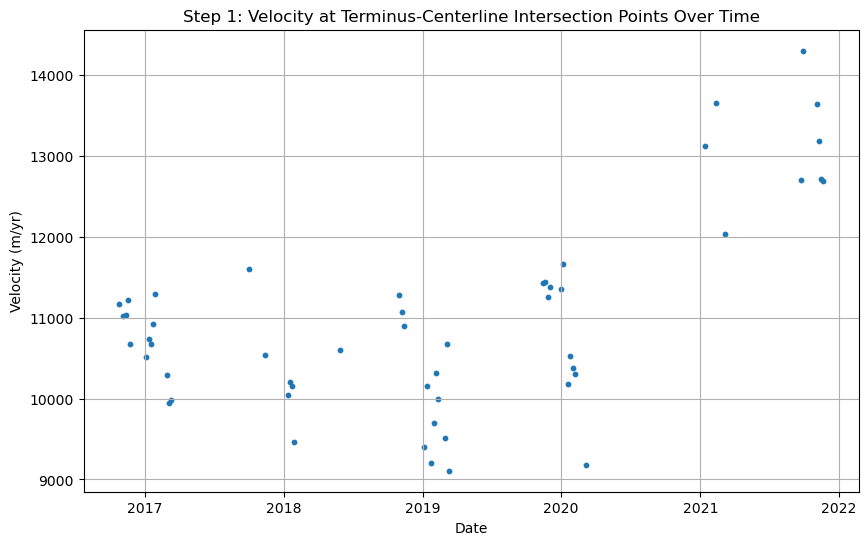

In [8]:
# Step 1: Visualize velocity at intersection points over time
plt.figure(figsize=(10, 6))
plt.scatter(terminus["Date"], terminus["vel_at_intersection"], s=10)
plt.xlabel("Date")
plt.ylabel("Velocity (m/yr)")
plt.title("Step 1: Velocity at Terminus-Centerline Intersection Points Over Time")
plt.grid(True)
plt.show()

### Step 2: If Step 1 is NaN then sample up the centreline until next valid velocity value

In [9]:
threshold = 1000  # meters along the centerline 
step = 10         # step between meters between sampled points on the centreline

vel_nearest_centreline = []
sampled_centreline_distance = []
sampled_centreline_point = []

for i in range(len(terminus)):

    # Run step 2 only if step 1 is Nan - i.e., vel_at_intersection is NaN
    if pd.notna(terminus["vel_at_intersection"].iloc[i]):
        vel_nearest_centreline.append(np.nan)
        sampled_centreline_distance.append(np.nan)
        sampled_centreline_point.append(np.nan)
        continue

    # Convert matched time to velocity index
    matched_time = terminus["matched_vel_time"].iloc[i]
    vel_time_index = int(np.where(vel_times == matched_time)[0][0])
    vel_slice = vel_band.isel(time=vel_time_index)

    # Distance along the centreline where the intersection point is
    d0 = centreline_shape.project(terminus["intersect_points"].iloc[i]) 
    # d_threshold = how long to search along the centreline from d0
    d_threshold = min(d0 + threshold, centreline_shape.length)

    vel_along_centreline = np.nan
    d_found = np.nan
    p_found = None

    for d in np.arange(d0, d_threshold + step, step): #start at isct .and then go up by step value
        p = centreline_shape.interpolate(float(d))  # point on the centreline
        v = vel_slice.sel(x=p.x, y=p.y, method="nearest").values #xarray nearest method
        v = np.asarray(v).item()  # make scalar

        if np.isfinite(v):
            vel_along_centreline = float(v)
            d_found = float(d)
            p_found = p
            break

    vel_nearest_centreline.append(vel_along_centreline)
    sampled_centreline_distance.append(d_found)
    sampled_centreline_point.append(p_found)

terminus["vel_nearest_centreline"] = vel_nearest_centreline
terminus["distance_up_centreline"] = sampled_centreline_distance
terminus["point_up_centreline"] = sampled_centreline_point

Number of NaN Step 2 velocity points: 238
Number of valid Step 2 velocity points: 119 out of 357


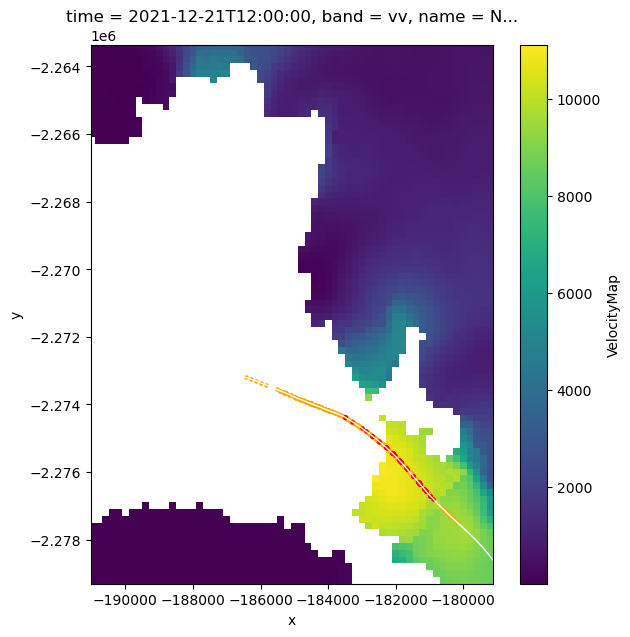

In [10]:
# Check to see how many are NaN
STEP2_none_vals = terminus["vel_nearest_centreline"].isna().sum()
print(f"Number of NaN Step 2 velocity points: {STEP2_none_vals}")

# Check to see how many as non NaN
STEP2_valid_vals = terminus["vel_nearest_centreline"].notna().sum()
print(f"Number of valid Step 2 velocity points: {STEP2_valid_vals} out of {len(terminus)}")

# Visualize where the points with valid Step 2 velocities are along the centreline
fig, ax = plt.subplots(figsize=(7, 7))

vel_slice.plot(
    ax=ax,
    x="x", 
    y="y", 
    add_colorbar=True)

# intersection points
terminus.set_geometry("intersect_points").plot(ax=ax, markersize=5, color="orange")

# sampled points along the centreline
terminus.set_geometry("point_up_centreline").plot(ax=ax, markersize=5, color="red")

#centreline
centreline_gs.plot(ax=ax, color="white", linewidth=1)

#zoom in order to see insct. better
xmin, ymin, xmax, ymax = terminus.total_bounds

z00m = 500

ax.set_xlim(xmin - z00m, xmax + z00m)
ax.set_ylim(ymin - z00m, ymax + z00m)

plt.show()

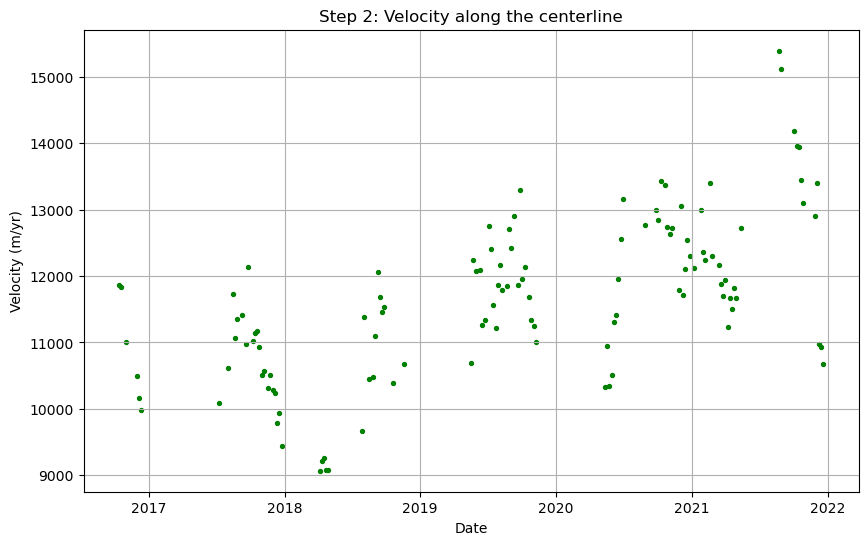

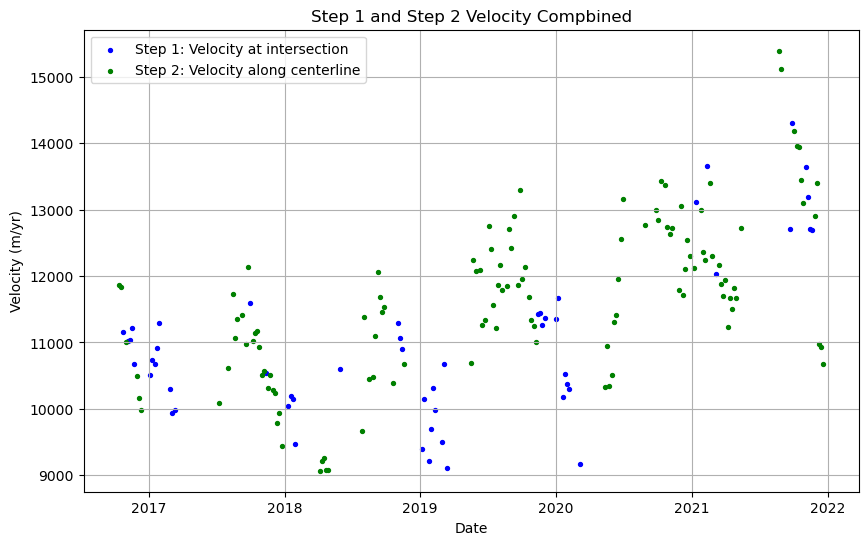

In [11]:
# Step 2: Visualize velocity at along the centerline
plt.figure(figsize=(10, 6))
plt.scatter(terminus["Date"], terminus["vel_nearest_centreline"], s=8, color = 'green')
plt.xlabel("Date")
plt.ylabel("Velocity (m/yr)")
plt.title("Step 2: Velocity along the centerline")
plt.grid(True)
plt.show()

# Step 1 and Step 2 combined visualization
plt.figure(figsize=(10, 6))
plt.scatter(terminus["Date"], terminus["vel_at_intersection"], s=8, color = 'blue', label="Step 1: Velocity at intersection")
plt.scatter(terminus["Date"], terminus["vel_nearest_centreline"], s=8, color = 'green', label="Step 2: Velocity along centerline")
plt.xlabel("Date") 
plt.ylabel("Velocity (m/yr)")
plt.title("Step 1 and Step 2 Velocity Compbined")
plt.legend()
plt.grid(True)
plt.show()

### Skip Step 3 for now...
Instead, interpolate based off existing found velocities
1. Before interpolation - smooth the data - take the rolling mean over 12-18 days: https://pandas.pydata.org/docs/reference/api/pandas.DataFrame.rolling.html
2. Use pandas: https://pandas.pydata.org/docs/reference/api/pandas.DataFrame.interpolate.html

In [12]:
valid_vels = STEP1_valid_vals + STEP2_valid_vals
print(f"Total valid velocity points from Step 1 and Step 2: {valid_vels} out of {len(terminus)}")

Total valid velocity points from Step 1 and Step 2: 171 out of 357


In [38]:
# combine Step 1 and Step 2 velocities into one column - combine_first takes Step 1 value if it exists, otherwise take Step 2 value
    # https://pandas.pydata.org/docs/reference/api/pandas.DataFrame.combine_first.html#pandas.DataFrame.combine_first 
terminus["vel_1_and_2"] = (terminus["vel_at_intersection"].combine_first(terminus["vel_nearest_centreline"]))

#window ="12D"  # 12 day rolling window
window = "18D"  # 18 day rolling window
smoothing = terminus.set_index("Date")["vel_1_and_2"].sort_index()
smoothed = smoothing.rolling(window, min_periods=1, center=True).mean()

smoothed_interp = smoothed.interpolate(method="time", limit=5)
terminus["vel_inter"] = smoothed_interp.reindex(terminus["Date"]).to_numpy()

# Check how many valid velocity points after interpolation
STEP3_none_vals = terminus["vel_inter"].isna().sum()
print(f"Number of NaN Step 3 velocity points: {STEP3_none_vals}")

# Check to see how many are non NaN
STEP3_valid_vals = terminus["vel_inter"].notna().sum()
print(f"Number of valid Step 3 velocity points: {STEP3_valid_vals} out of {len(terminus)}") 

Number of NaN Step 3 velocity points: 79
Number of valid Step 3 velocity points: 278 out of 357


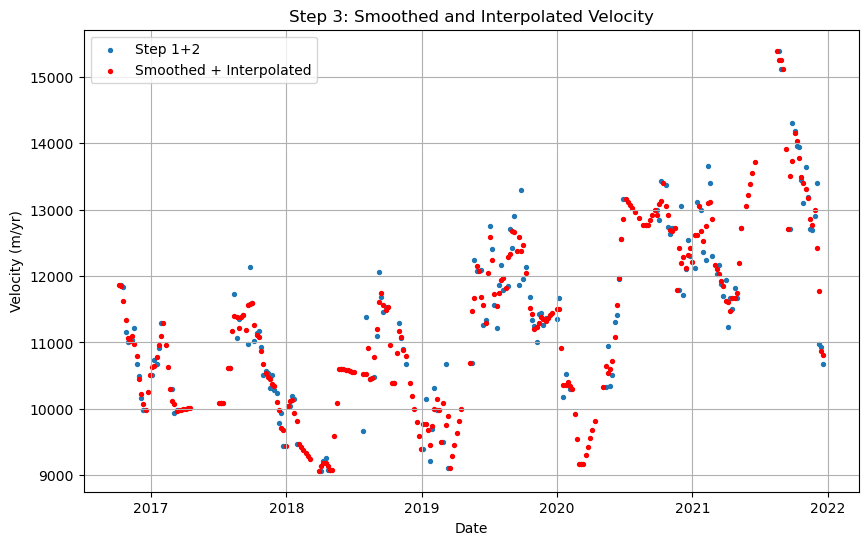

In [51]:
# Step 3: Visualize smoothed and interpolated velocity
plt.figure(figsize=(10,6))
plt.scatter(terminus["Date"], terminus["vel_1_and_2"], s=8, label="Step 1+2")
plt.scatter(terminus["Date"], terminus["vel_inter"], s=8, color='red', label="Smoothed + Interpolated")
plt.legend()
plt.grid(True)
plt.xlabel("Date")
plt.ylabel("Velocity (m/yr)")
plt.title("Step 3: Smoothed and Interpolated Velocity")
plt.show()

In [50]:
nan_dates = terminus.loc[terminus["vel_inter"].isna(), "Date"].tolist()
print(nan_dates)
    # so there are a lot of missing velocity values at the beginning of the time series
        #BUT there are valid velocity values from the original MEaSUREs velocity data at the beginning of the time series 

print("First valid velocity date:",
      terminus.loc[terminus["vel_1_and_2"].notna(), "Date"].min())

print("Last valid velocity date:",
      terminus.loc[terminus["vel_1_and_2"].notna(), "Date"].max())

[Timestamp('2015-01-03 00:00:00'), Timestamp('2015-01-15 00:00:00'), Timestamp('2015-01-27 00:00:00'), Timestamp('2015-02-08 00:00:00'), Timestamp('2015-02-20 00:00:00'), Timestamp('2015-03-04 00:00:00'), Timestamp('2015-03-16 00:00:00'), Timestamp('2015-03-28 00:00:00'), Timestamp('2015-04-09 00:00:00'), Timestamp('2015-04-21 00:00:00'), Timestamp('2015-05-03 00:00:00'), Timestamp('2015-05-15 00:00:00'), Timestamp('2015-05-27 00:00:00'), Timestamp('2015-06-08 00:00:00'), Timestamp('2015-07-26 00:00:00'), Timestamp('2015-08-07 00:00:00'), Timestamp('2015-08-19 00:00:00'), Timestamp('2015-08-31 00:00:00'), Timestamp('2015-09-12 00:00:00'), Timestamp('2015-10-18 00:00:00'), Timestamp('2015-11-11 00:00:00'), Timestamp('2015-11-23 00:00:00'), Timestamp('2015-12-05 00:00:00'), Timestamp('2015-12-17 00:00:00'), Timestamp('2015-12-29 00:00:00'), Timestamp('2016-01-10 00:00:00'), Timestamp('2016-01-22 00:00:00'), Timestamp('2016-02-03 00:00:00'), Timestamp('2016-02-15 00:00:00'), Timestamp('20

Text(0.5, 1.0, 'Valid Velocity Count (2015–2016)')

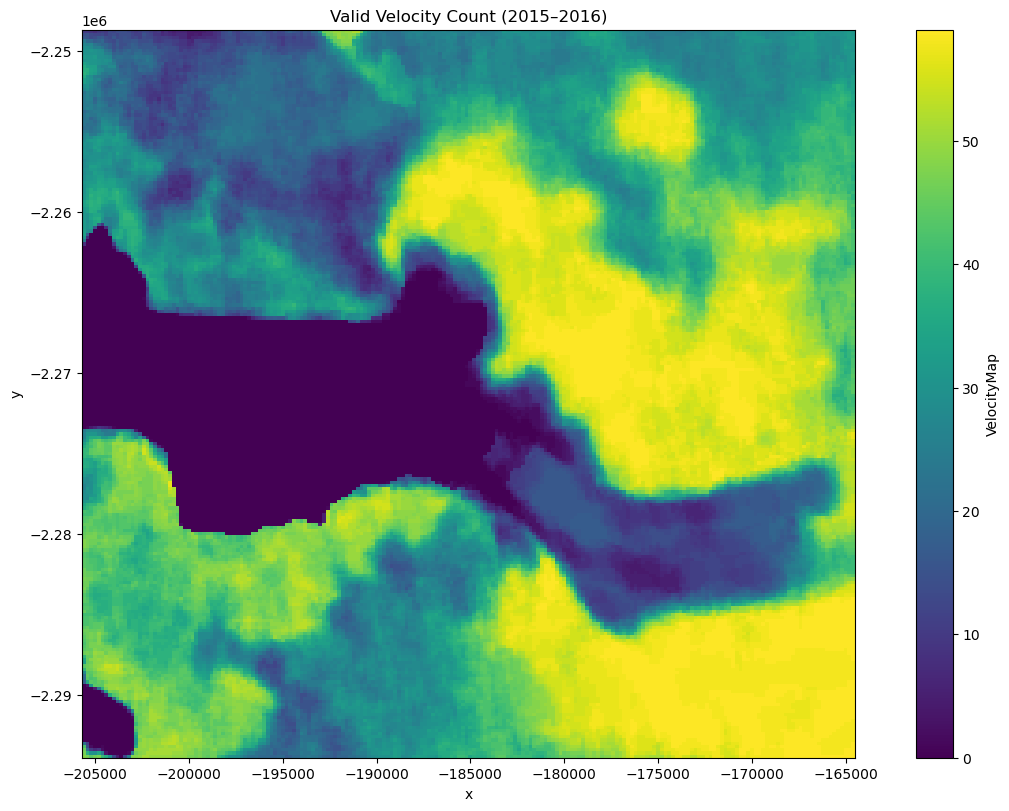

In [55]:
mask = (vel_times >= "2015-01-01") & (vel_times <= "2016-12-31")

vel_mask = vel_band.isel(time=mask)

valid_count_early = vel_mask.count(dim="time")

fig, ax = plt.subplots(figsize=(10,8), constrained_layout=True)

valid_count_early.plot(
    ax=ax,
    x="x",
    y="y",
    add_colorbar=True,
)

ax.set_title("Valid Velocity Count (2015–2016)")

In [60]:
terminus["vel_final"] = terminus["vel_1_and_2"].combine_first(terminus["vel_inter"])

In [61]:
centreline_maqit = pd.read_csv(centreline_maqit_path, skiprows=1)


centreline_maqit["Date"] = pd.to_datetime(
    dict(Year=centreline_maqit["Year"],
        Month=centreline_maqit["Month"],
        Day=centreline_maqit["Day"])
)

cl = centreline_maqit[[
    "Date",
    "Terminus Position on flowline",
    "Terminus change (m)"
]]

cl = cl.rename(columns = {
    "Terminus Position on flowline": "L", 
    "Terminus change (m)": "del_L"
})

cl

#merge to terminus set

terminus = terminus.merge(cl)
terminus = terminus.sort_values("Date").reset_index(drop=True)

#dt calc
terminus["dt_days"] = terminus["Date"].diff().dt.days
terminus["dt_years"] = terminus["dt_days"] / 365.25

#dt calc
terminus["dL"] = terminus["L"].diff()
terminus["dLdt"] = terminus["dL"] / terminus["dt_years"]

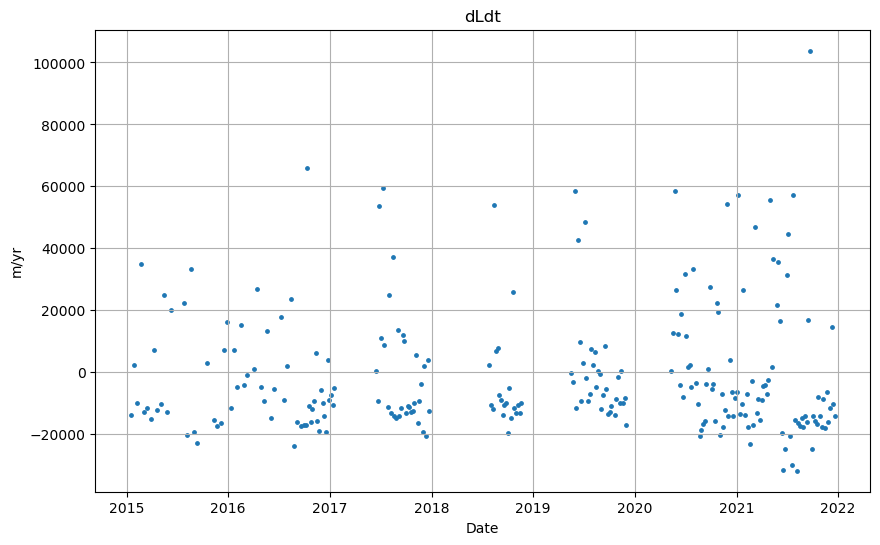

In [69]:
fig, ax = plt.subplots(figsize = (10,6))
ax.scatter(terminus["Date"], terminus["dLdt"], s=6, label = "dLdt m/yr" )
plt.title("dLdt")
ax.set_xlabel("Date")
ax.set_ylabel("m/yr")
plt.grid(True)
plt.show()

In [63]:
terminus["calving"] = terminus["vel_final"] - terminus["dLdt"]
terminus["calving_magnitude"] = terminus["calving"]/365.25

Calving events are positive:
- dLdt > 0 means length is increasing with time - i.e., advance 
- dLdT < 0 means length is decreasing with time - i.e., retreat
    - according to plot dLdt is primarily negative
- vel > 0 flowing towards terminus 

So calving = positve value - negative value, therefore, calving is positive 

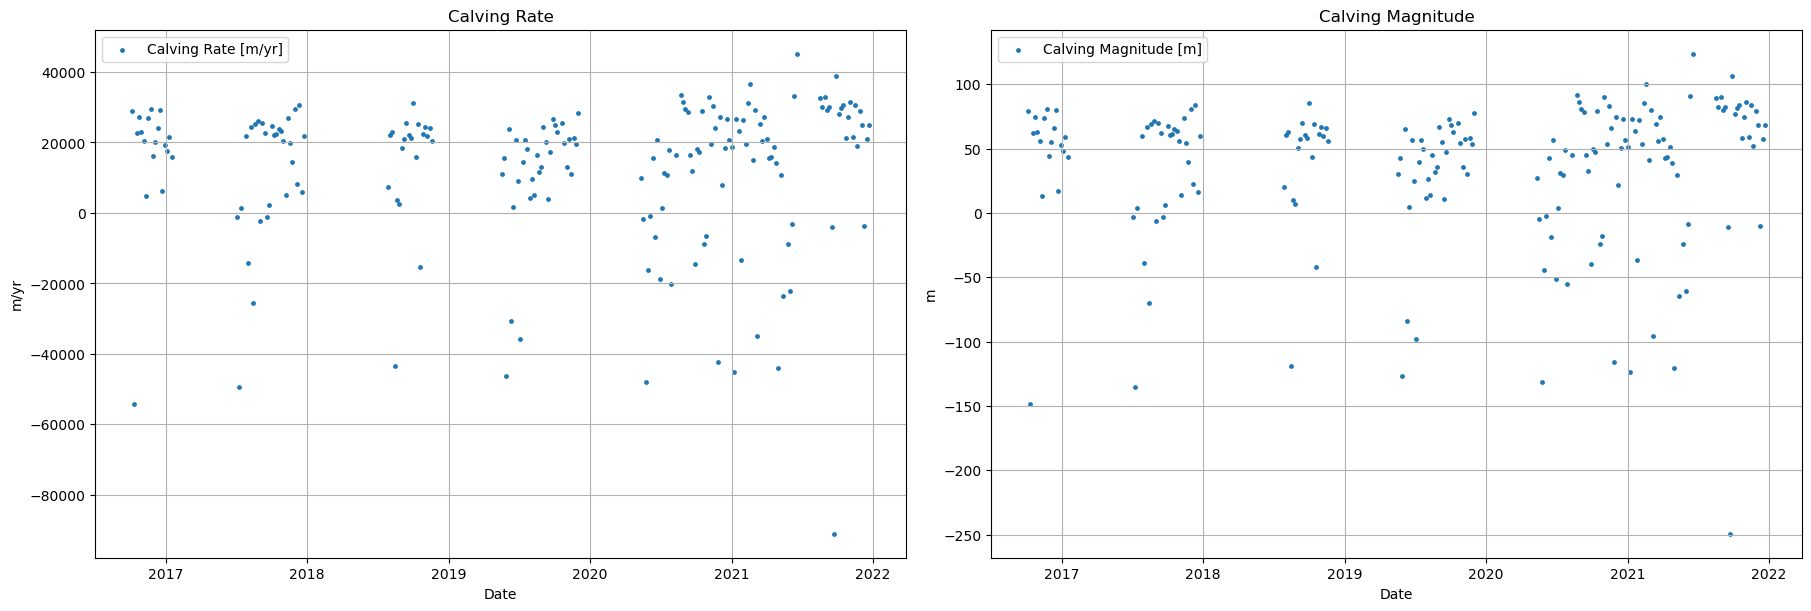

In [80]:
fig, ax = plt.subplots(1, 2, figsize = (18,6), constrained_layout=True)

ax[0].scatter(terminus["Date"], terminus["calving"], s=6,  label = "Calving Rate [m/yr]" )
ax[0].set_title("Calving Rate")
ax[0].set_xlabel("Date")
ax[0].set_ylabel("m/yr")
ax[0].grid(True)
ax[0].legend()

ax[1].scatter(terminus["Date"], terminus["calving_magnitude"], s=6, label = "Calving Magnitude [m]" )
ax[1].set_title("Calving Magnitude")
ax[1].set_xlabel("Date")
ax[1].set_ylabel("m")
ax[1].grid(True)
ax[1].legend()
plt.show()

## Skipping Step 3 (for now)

### Step 3: If Step 1 & 2 are NaN, then find the most recent valid velocity in time 

Going back in time, assign the most recent prior observed velocity at that location, but record the date of the source velocity and how much that time was offset too. 

In [12]:
terminus = terminus.sort_values("Date").reset_index(drop=True)

vel_most_recent = []
vel_most_recent_time = []
vel_most_recent_time_diff = []

for i in range(len(terminus)):

    # only run step 3 if step 1 (intersection) and step 2 (along centerline) failed
    if (
        pd.notna(terminus["vel_at_intersection"].iloc[i]) or
        pd.notna(terminus["vel_nearest_centreline"].iloc[i])
    ):
        vel_most_recent.append(np.nan)
        vel_most_recent_time.append(pd.NaT)
        vel_most_recent_time_diff.append(np.nan)    
        continue
 
    pt = terminus["intersect_points"].iloc[i]
    matched_time = terminus["matched_vel_time"].iloc[i]

    #starting point for looking = closest time 
    t_start = int(np.argmin(np.abs(vel_times - matched_time)))

    recent_vel = np.nan
    recent_time = pd.NaT

# look backwards in time for most recent valid velocity
    for time_val in range(t_start, -1, -1):

        v = vel_slice.sel(x=pt.x, y=pt.y, method="nearest").values #xarray nearest method
        v = np.asarray(v).item()

        if np.isfinite(v):
            recent_vel = float(v)
            recent_time = vel_times[time_val]
            break

        if (matched_time - vel_times[time_val]) > pd.Timedelta(days=50):  # dont go back more than 50 days
            break

    vel_most_recent.append(recent_vel)
    vel_most_recent_time.append(recent_time)
    vel_most_recent_time_diff.append((pd.to_datetime(matched_time) - pd.to_datetime(recent_time)).days if pd.notna(recent_time) else np.nan)

terminus["vel_most_recent"] = vel_most_recent
terminus["vel_most_recent_time"] = vel_most_recent_time
terminus["vel_most_recent_time_diff"] = vel_most_recent_time_diff

In [13]:
# Check to see how many are NaN
STEP3_none_vals = terminus["vel_most_recent"].isna().sum()
print(f"Number of NaN Step 3 velocity points: {STEP3_none_vals}")

# Check to see how many as non NaN
STEP3_valid_vals = terminus["vel_most_recent"].notna().sum()
print(f"Number of valid Step 3 velocity points: {STEP3_valid_vals} out of {len(terminus)}")

Number of NaN Step 3 velocity points: 279
Number of valid Step 3 velocity points: 78 out of 357


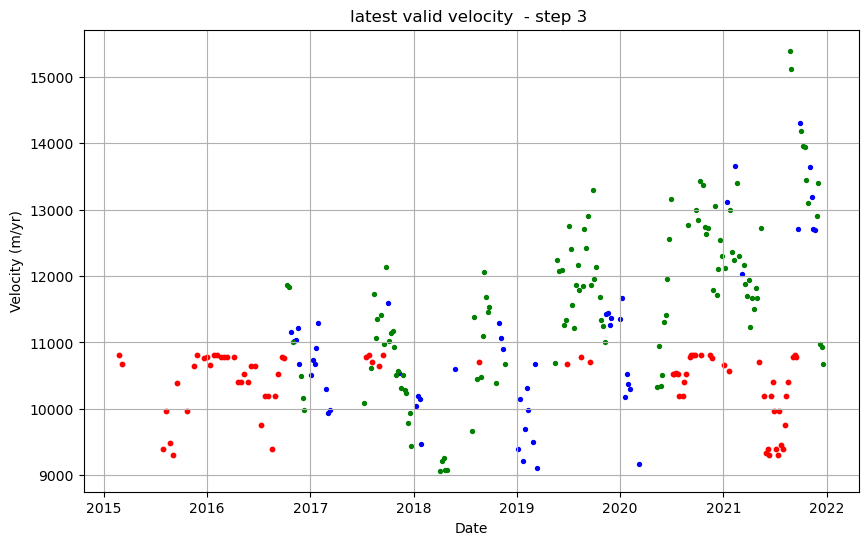

In [16]:
plt.figure(figsize=(10, 6))
plt.scatter(terminus["vel_most_recent_time"], terminus["vel_most_recent"], s=10, c="red")
plt.scatter(terminus["Date"], terminus["vel_at_intersection"], s=8, color = 'blue', label="Step 1: Velocity at intersection")
plt.scatter(terminus["Date"], terminus["vel_nearest_centreline"], s=8, color = 'green', label="Step 2: Velocity along centerline")
plt.xlabel("Date")
plt.ylabel("Velocity (m/yr)")
plt.title("latest valid velocity  - step 3 ")
plt.grid(True)
plt.show()

Before interpolation - smooth data - take rolling mean over 12-18 days - https://pandas.pydata.org/docs/reference/api/pandas.DataFrame.rolling.html
and then interpolate 
Try interpolation via geopandas instead of xarray


In [ ]:
#combining

terminus["vel_combined"] = (
    terminus["vel_at_intersection"]
    .combine_first(terminus["vel_nearest_centreline"])
    .combine_first(terminus["vel_most_recent"])
)

number_of_valid_combined= terminus["vel_combined"].notna().sum()
print(number_of_valid_combined)

#but remembring there was 111 intersection nans to begin with so im never gonna have more that 246 valid values

terminus = terminus.sort_values("Date").reset_index(drop=True)

# interpolate remaining NaNs -- interpolate via geopanda
da = xr.DataArray(
    terminus["vel_combined"].values,
    coords={"time": pd.to_datetime(terminus["Date"])},
    dims="time"
)

da_interp = da.interpolate_na(
    dim="time",
    method="linear",
    max_gap=np.timedelta64(100, "D")
)

terminus["vel_final"] = da_interp.values
number_of_valid_final = terminus["vel_final"].notna().sum()

print(number_of_valid_final)


195
199


In [38]:
print("valid combined:", terminus["vel_combined"].notna().sum())
print("valid final   :", terminus["vel_final"].notna().sum())
print("filled by interp:", (terminus["vel_combined"].isna() & terminus["vel_final"].notna()).sum())


valid combined: 195
valid final   : 199
filled by interp: 4


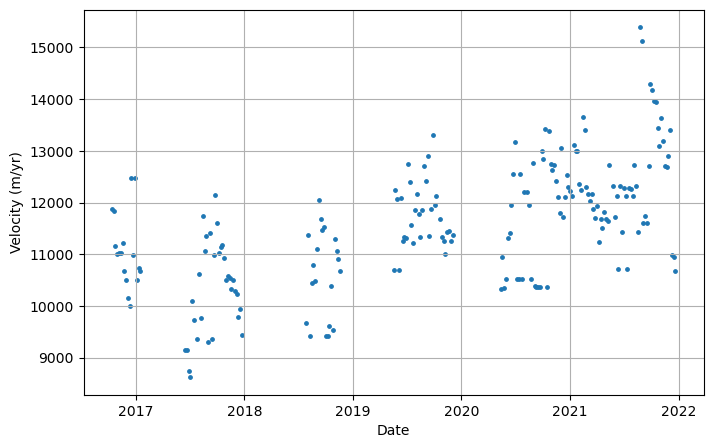

In [41]:
plt.figure(figsize=(8, 5))
plt.scatter(terminus["Date"], terminus["vel_final"], s=6)
plt.xlabel("Date")
plt.ylabel("Velocity (m/yr)")
plt.grid(True)
plt.show()

In [35]:
centreline_maqit = pd.read_csv(centreline_maqit_path, skiprows=1)


centreline_maqit["Date"] = pd.to_datetime(
    dict(Year=centreline_maqit["Year"],
        Month=centreline_maqit["Month"],
        Day=centreline_maqit["Day"])
)

cl = centreline_maqit[[
    "Date",
    "Terminus Position on flowline",
    "Terminus change (m)"
]]

cl = cl.rename(columns = {
    "Terminus Position on flowline": "L", 
    "Terminus change (m)": "del_L"
})

cl

#merge to terminus set

terminus = terminus.merge(cl)
terminus = terminus.sort_values("Date").reset_index(drop=True)


In [42]:
#dt calc
terminus["dt_days"] = terminus["Date"].diff().dt.days
terminus["dt_years"] = terminus["dt_days"] / 365.25

#dt calc
terminus["dL"] = terminus["L"].diff()
terminus["dLdt"] = terminus["dL"] / terminus["dt_years"]

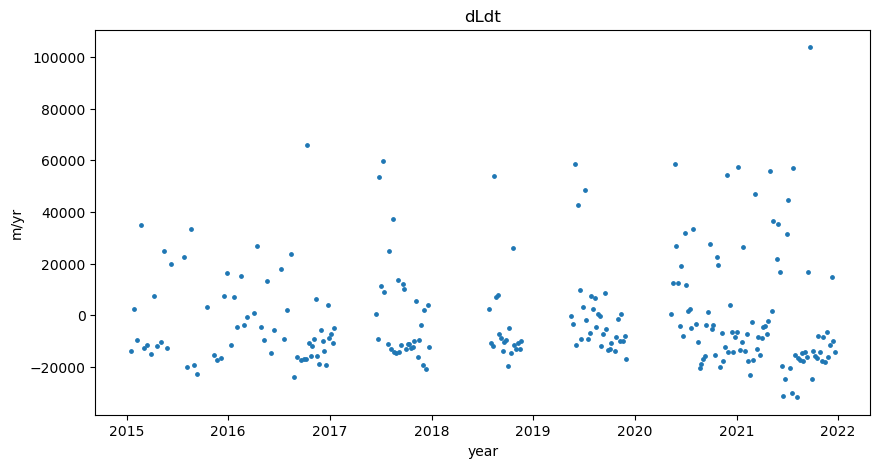

In [43]:
fig, ax = plt.subplots(figsize = (10,5))
ax.scatter(terminus["Date"], terminus["dLdt"], s=6, label = "dLdt m/yr" )
plt.title("dLdt")
ax.set_xlabel("year")
ax.set_ylabel("m/yr")
plt.show()

In [44]:
terminus["calving"] = terminus["vel_final"] - terminus["dLdt"]
terminus["calving_magnitude"] = terminus["calving"]/365.25

Calving events are positive:
- dLdt > 0 means length is increasing with time - i.e., advance 
- dLdT < 0 means length is decreasing with time - i.e., retreat
    - according to plot dLdt is priamrly negativ
- vel > 0 flowing towards terminus 

So calving = positve value - negative value, therefore, calving is positive 

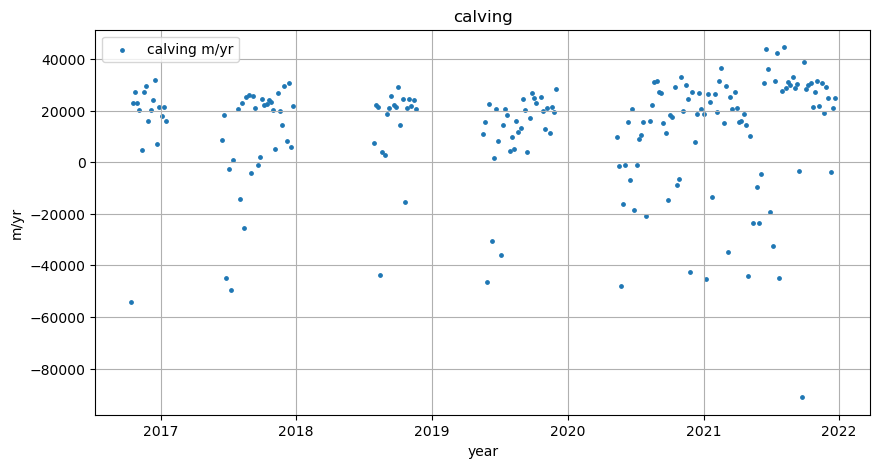

In [ ]:
fig, ax = plt.subplots(figsize = (10,5))

ax.scatter(terminus["Date"], terminus["calving"], s=6,  label = "calving m/yr" )
plt.title("calving")
ax.set_xlabel("year")
ax.set_ylabel("m/yr")
ax.grid(True)
ax.legend()
plt.show()

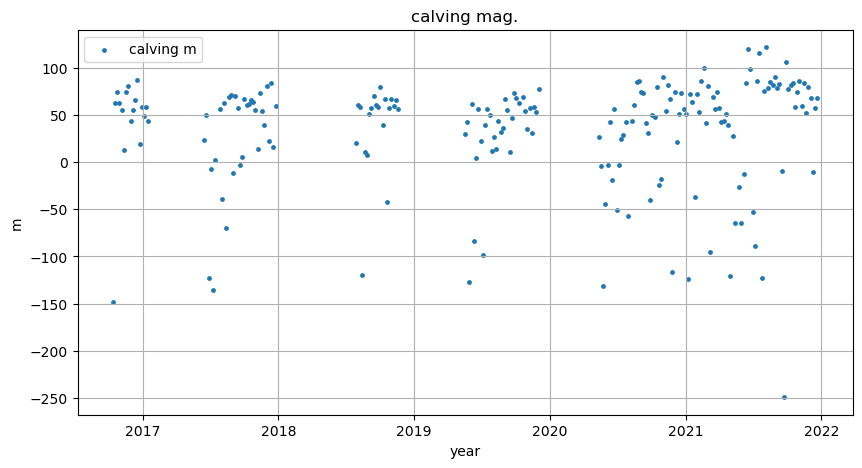

In [46]:
fig, ax = plt.subplots(figsize = (10,5))

ax.scatter(terminus["Date"], terminus["calving_magnitude"], s=6, label = "calving m" )
plt.title("calving mag.")
ax.set_xlabel("year")
ax.set_ylabel("m")
ax.grid(True)
ax.legend()
plt.show()

#Step 4: Having all the slow velocities be NaN anywhere where it is below 1000 m/yr we replace it w NaN - i.e., if you use a buffer logic
    -  use buffer and thnen mask in slow 


Ignore code below for now - will work on implementing buffer logic soon

### Step 4: Use buffer as a last resort?

In [10]:
# xarray slice will only work if the cooridante is sorter the way the slice assumes, i.e., y is increasing from first to last 
def nearest_buffer(velocity, x0, y0, buffer = 1000):
    """nearest non-nan value to (x0,y0) within a buffer."""
    # subset window (handle y increasing/decreasing) - #xarray slicing depends on whether y coordinates increase or decrease
    y_increasing = float(velocity["y"][0]) < float(velocity["y"][-1])
    y_slice = slice(y0 - buffer, y0 + buffer) if y_increasing else slice(y0 + buffer, y0 - buffer)

#subset velocity into buffer window 
    subset_velocity = velocity.sel(
        x=slice(x0 - buffer, x0 + buffer),
        y=y_slice,
    )

    # if everything is NaN --> return NaN
    if int(subset_velocity.notnull().sum()) == 0:
        return np.nan

    # squared distance field (xarray broadcasts x and y across (y,x))
    distance = (subset_velocity["x"] - x0) ** 2 + (subset_velocity["y"] - y0) ** 2 #basically like the distance equation
    # ignore distances where velocity is NaN
    distance = distance.where(subset_velocity.notnull())

    # stack to 1D so we can pick a single closest element cleanly
    distances = distance.stack(pixel=("y", "x"))
    velocities = subset_velocity.stack(pixel=("y", "x"))

    # label of the minimum-distance element
    nearest_pixel= distances.idxmin("pixel")

    # return the velocity at that element
    return float(velocities.sel(pixel=nearest_pixel).values)


In [17]:
buffer_dist = 1000 

vel_nearest = []
matched_vel_time = []

for i in range(len(terminus)):
    pt = terminus["intersect_points"].iloc[i]

    # skip if no intersection point
    if (pt is None) or (hasattr(pt, "is_empty") and pt.is_empty):
        vel_nearest.append(np.nan)
        matched_vel_time.append(pd.NaT) #store not a time (NaT) for the velocity 
        continue

    # terminus date
    t_term = pd.to_datetime(terminus["Date"].iloc[i])

    # nearest velocity time index
    vel_time_index= int(np.argmin(np.abs(vel_times - t_term)))
    matched_vel_time.append(vel_times[vel_time_index])

    # velocity slice at that nearest time
    vel_slice = vel_band.isel(time=vel_time_index)

    # nearest valid velocity within buffer around the point
    v = nearest_buffer(vel_slice, pt.x, pt.y, buffer=buffer_dist)
    vel_nearest.append(v)

terminus["vel_nearest_buffer"] = vel_nearest
terminus["matched_vel_time"] = matched_vel_time


0
357


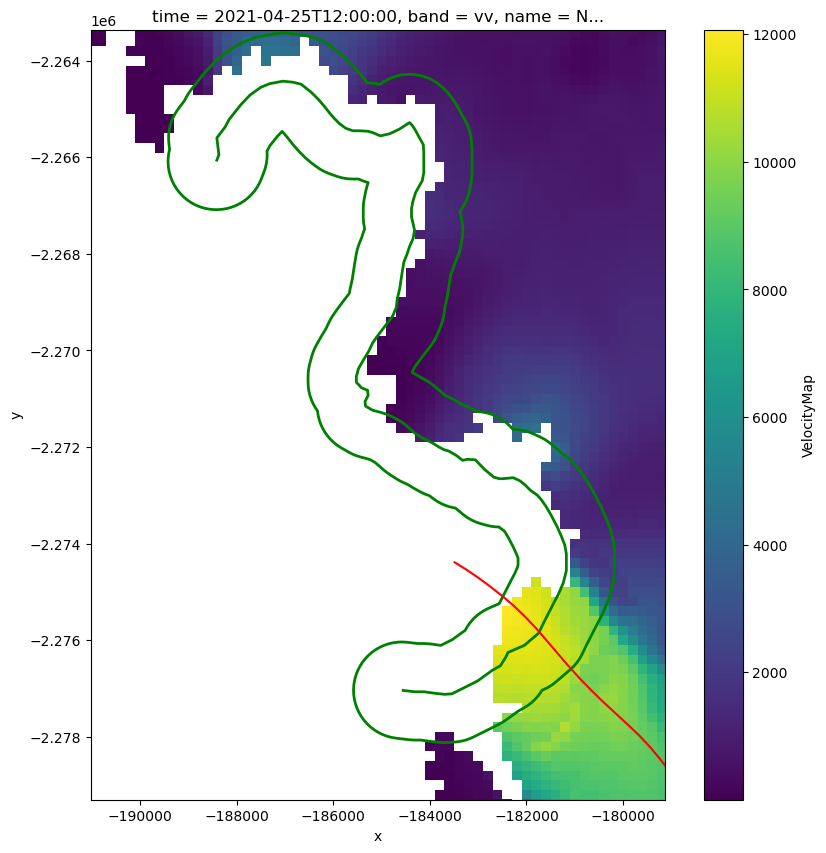

In [18]:
#intersect points 
sampletime = 113

vel_slice = vel_band.isel(time=sampletime)  
fig, ax = plt.subplots(figsize=(10, 10))

valid_count.plot(
    ax=ax,
    x="x",
    y="y",
    add_colorbar=True,
)

terminus.set_geometry("intersect_points").plot(
    ax=ax,
    color="red",
    markersize=10,
)

centreline_gs.plot(ax=ax, color="white", linewidth=1.5)

#zoom in order to see insct. better
xmin, ymin, xmax, ymax = terminus.total_bounds

z00m = 500  

ax.set_xlim(xmin - z00m, xmax + z00m)
ax.set_ylim(ymin - z00m, ymax + z00m)

plt.show()

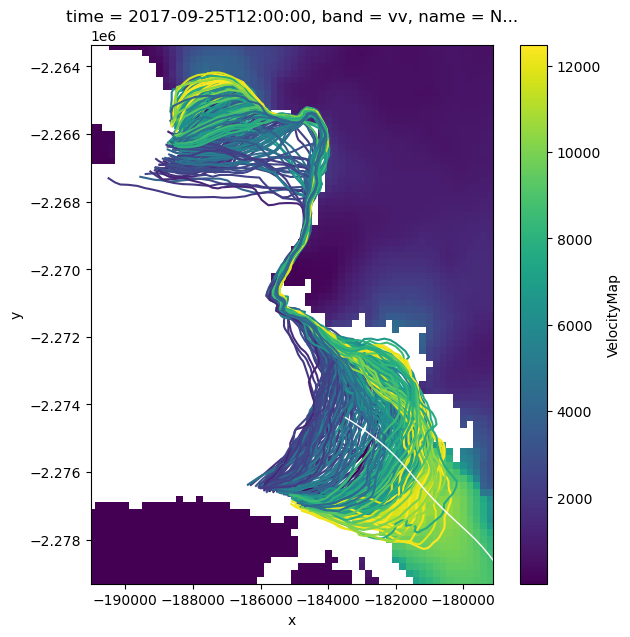

In [14]:
fig, ax = plt.subplots(figsize=(7, 7))

# velocity raster
vel_slice.plot(ax=ax, x="x", y="y", add_colorbar=True)

# plot sampled velocities as points
terminus.plot(
    ax=ax,
    column="vel_nearest_buffer",
    markersize=15,
)

centreline_gs.plot(ax=ax, color="white", linewidth=1)

#zoom in order to see insct. better
xmin, ymin, xmax, ymax = terminus.total_bounds

z00m = 500  

ax.set_xlim(xmin - z00m, xmax + z00m)
ax.set_ylim(ymin - z00m, ymax + z00m)

plt.show()


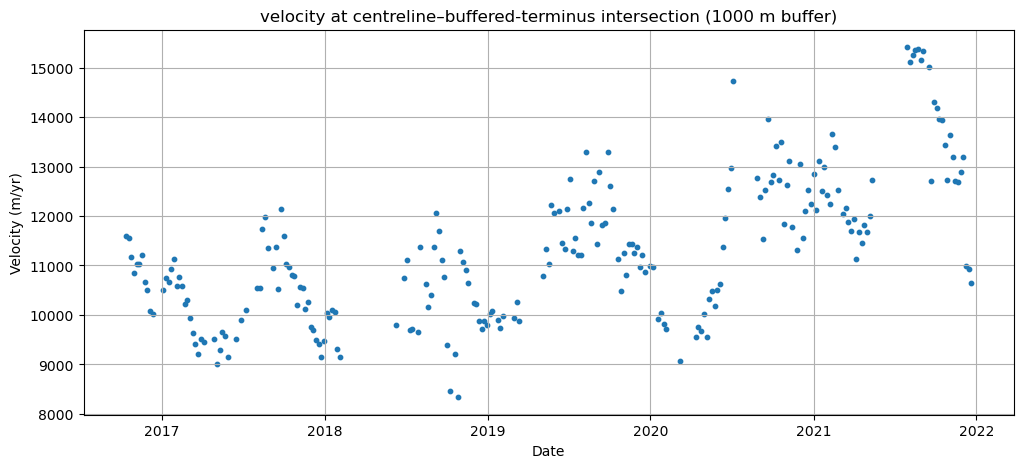

In [ ]:
plt.figure(figsize=(12, 5))
plt.scatter(terminus["Date"], terminus["vel_nearest_buffer"], s=10)
plt.xlabel("Date")
plt.ylabel("Velocity (m/yr)")
plt.title("velocity at centreline–buffered-terminus intersection")
plt.grid(True)
plt.show()

In [16]:
centreline_maqit = pd.read_csv(centreline_maqit_path, skiprows=1)


centreline_maqit["Date"] = pd.to_datetime(
    dict(Year=centreline_maqit["Year"],
        Month=centreline_maqit["Month"],
        Day=centreline_maqit["Day"])
)

cl = centreline_maqit[[
    "Date",
    "Terminus Position on flowline",
    "Terminus change (m)"
]]

cl = cl.rename(columns = {
    "Terminus Position on flowline": "L", 
    "Terminus change (m)": "del_L"
})

cl

#merge to terminus set

terminus = terminus.merge(cl)
terminus = terminus.sort_values("Date").reset_index(drop=True)


In [17]:
#dt calc
terminus["dt_days"] = terminus["Date"].diff().dt.days
terminus["dt_years"] = terminus["dt_days"] / 365.25

#dt calc
terminus["dL"] = terminus["L"].diff()
terminus["dLdt"] = terminus["dL"] / terminus["dt_years"]

In [18]:
terminus["calving"] = terminus["vel_nearest_buffer"] - terminus["dLdt"]
terminus["calving_magnitude"] = terminus["calving"]/365.25

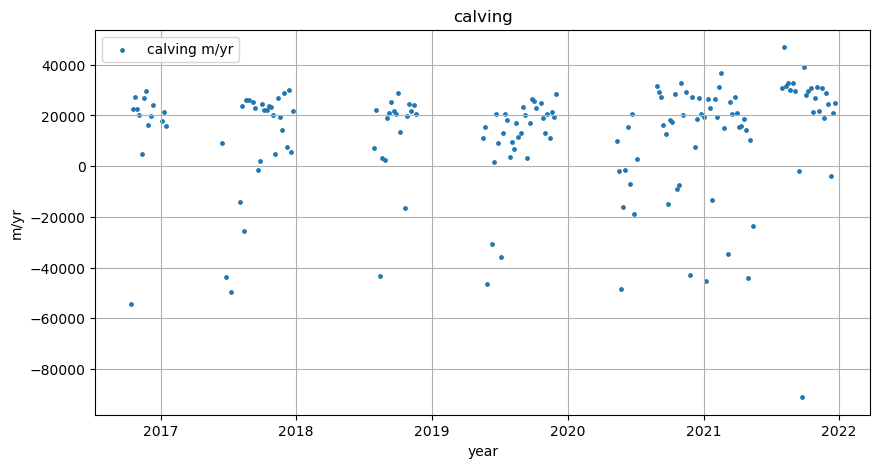

In [19]:
fig, ax = plt.subplots(figsize = (10,5))

ax.scatter(terminus["Date"], terminus["calving"], s=6,  label = "calving m/yr" )
plt.title("calving")
ax.set_xlabel("year")
ax.set_ylabel("m/yr")
ax.grid(True)
ax.legend()
plt.show()


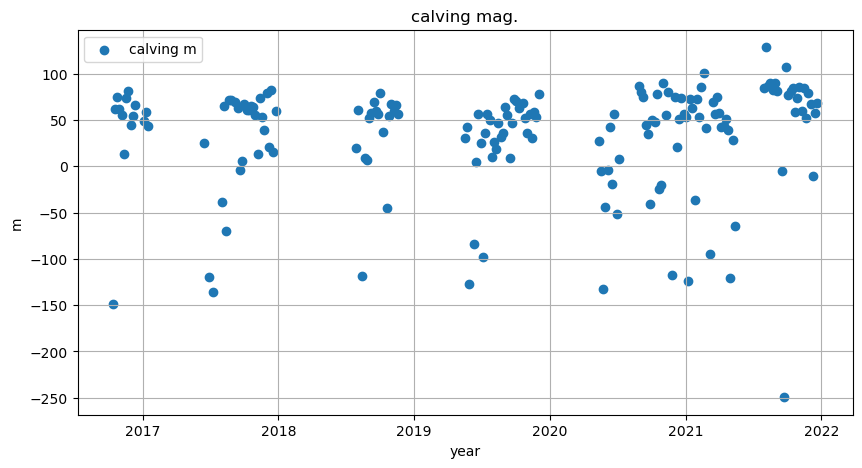

In [20]:
fig, ax = plt.subplots(figsize = (10,5))

ax.scatter(terminus["Date"], terminus["calving_magnitude"],  label = "calving m" )
plt.title("calving mag.")
ax.set_xlabel("year")
ax.set_ylabel("m")
ax.grid(True)
ax.legend()
plt.show()

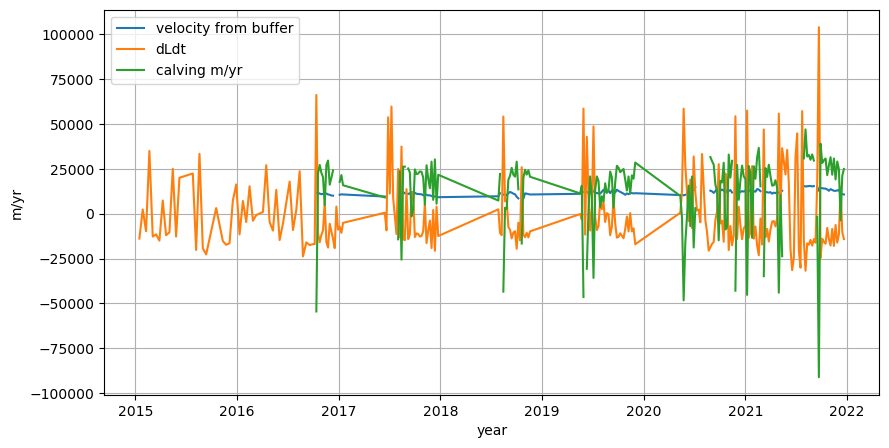

In [21]:

fig, ax = plt.subplots(figsize=(10,5))

ax.plot(terminus["Date"], terminus["vel_nearest_buffer"], label = "velocity from buffer" )
ax.plot(terminus["Date"], terminus["dLdt"], label = "dLdt")
ax.plot(terminus["Date"], terminus["calving"],  label = "calving m/yr" )

ax.set_xlabel("year")
ax.set_ylabel("m/yr")
ax.grid(True)
ax.legend()
plt.show()


In [22]:
#this is was original attempt using u = 1500 m/yr

In [23]:
terminus

,Image_ID,Image_Tile,Date,Quality_Fl,Glacier_ID,geometry,intersect_points,buffer_was_used,vel_nearest_buffer,matched_vel_time,L,del_L,dt_days,dt_years,dL,dLdt,calving,calving_magnitude
0,SEN1_NSIDC_0723_V2_20150101_20150112,S1A_090_004012,2015-01-03,0,3,"LINESTRING (-188606.112 -2265922.891, -188399....",POINT (-182302.334 -2275255.03),False,NaN,2015-01-06 12:00:00,1492.80,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,SEN1_NSIDC_0723_V2_20150113_20150124,S1A_090_004187,2015-01-15,1,3,"LINESTRING (-188634.464 -2265910.404, -188629....",POINT (-182654.581 -2274965.158),False,NaN,2015-01-18 12:00:00,1036.50,-456.270,12.0,0.032854,-456.30,-13888.631250,NaN,NaN
2,SEN1_NSIDC_0723_V2_20150125_20150205,S1A_090_004362,2015-01-27,1,3,"LINESTRING (-186068.771 -2276605.242, -185814....",POINT (-182594.664 -2275012.206),False,NaN,2015-01-30 12:00:00,1112.70,76.181,12.0,0.032854,76.20,2319.337500,NaN,NaN
3,SEN1_NSIDC_0723_V2_20150206_20150217,S1A_090_004537,2015-02-08,0,3,"LINESTRING (-184745.971 -2277111.477, -184132....",POINT (-182850.188 -2274815.931),False,NaN,2015-02-11 12:00:00,790.49,-322.240,12.0,0.032854,-322.21,-9807.266875,NaN,NaN
4,SEN1_NSIDC_0723_V4_20150218_20150301,S1A_090_004712,2015-02-20,0,3,"LINESTRING (-185068.764 -2276846.893, -184507....",POINT (-181981.373 -2275562.417),False,NaN,2015-02-23 12:00:00,1937.40,1146.900,12.0,0.032854,1146.91,34909.073125,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
241,SEN1_NSIDC_0723_V4_20211125_20211130,S1A_090_040762,2021-11-27,0,3,"LINESTRING (-185111.097 -2276688.143, -184878....",POINT (-182377.56 -2275191.078),False,12899.083984,2021-11-27 12:00:00,1394.10,-264.480,6.0,0.016427,-264.50,-16101.437500,29000.521484,79.399101
242,SEN1_NSIDC_0723_V4_20211201_20211206,S1B_090_029866,2021-12-03,1,3,"LINESTRING (-185164.014 -2276666.976, -184867....",POINT (-182522.167 -2275069.131),False,13190.623047,2021-12-03 12:00:00,1204.90,-189.170,6.0,0.016427,-189.20,-11517.550000,24708.173047,67.647291
243,SEN1_NSIDC_0723_V4_20211207_20211212,S1A_090_040937,2021-12-09,1,3,"LINESTRING (-184931.18 -2276910.393, -184380.8...",POINT (-182337.446 -2275225.18),False,10982.209961,2021-12-09 12:00:00,1446.70,241.830,6.0,0.016427,241.80,14719.575000,-3737.365039,-10.232348
244,SEN1_NSIDC_0723_V4_20211213_20211218,S1B_090_030041,2021-12-15,1,3,"LINESTRING (-184793.596 -2276973.893, -184497....",POINT (-182464.429 -2275117.227),False,10937.859375,2021-12-15 12:00:00,1280.10,-166.670,6.0,0.016427,-166.60,-10141.775000,21079.634375,57.712894


In [24]:
#change to date time (this is a thing)
terminus["Date"] = pd.to_datetime(
    dict(year = terminus["Year"],
        month = terminus["Month"],
        day = terminus["Day"])
)

terminus = terminus.rename(columns = {
    "Terminus Position on flowline": "L",
    "Terminus change (m)": "del_L"
})

#for simplicity i just want these (for now, tbd)
terminus_columns = ["Date", "L", "del_L"]
terminus = terminus[terminus_columns].sort_values("Date").reset_index(drop= True)


KeyError: 'Year'

In [ ]:
#terminus df 
df = terminus.copy().sort_values("Date").reset_index(drop=True)

#dt calc
df["dt_days"] = df["Date"].diff().dt.days
df["dt_years"] = df["dt_days"] / 365.25

#dt calc
df["dL"] = df["L"].diff()
df["dLdt_per_year"] = df["dL"] / df["dt_years"]

df[["Date", "L", "dt_days", "dL", "dLdt_per_year"]].head(10)

#dLdt = dL ( 6 days) - terminus change between data / dt (per year)



,Date,L,dt_days,dL,dLdt_per_year
0,2015-01-03,1492.80,NaN,NaN,NaN
1,2015-01-15,1036.50,12.0,-456.30,-13888.631250
2,2015-01-27,1112.70,12.0,76.20,2319.337500
3,2015-02-08,790.49,12.0,-322.21,-9807.266875
4,2015-02-20,1937.40,12.0,1146.91,34909.073125
5,2015-03-04,1518.00,12.0,-419.40,-12765.487500
6,2015-03-16,1139.70,12.0,-378.30,-11514.506250
7,2015-03-28,645.19,12.0,-494.51,-15051.648125
8,2015-04-09,884.89,12.0,239.70,7295.868750
9,2015-04-21,489.40,12.0,-395.49,-12037.726875


In [ ]:
#so w my velocity i should pick a point on the terminus right 
# - probably where it intersects the centreline

centreline.length

0    564300.353452
dtype: float64

In [ ]:
vv = velocity["VelocityMap"].sel(band="vv")
print("min, max:", float(vv.min()), float(vv.max()))

min, max: 0.006762796081602573 16439.25


In [ ]:
xmin, xmax = float(vv.x.min()), float(vv.x.max())
ymin, ymax = float(vv.y.min()), float(vv.y.max())
print(xmin, xmax, ymin, ymax)

-194000.0 -170000.0 -2288000.0 -2264000.0


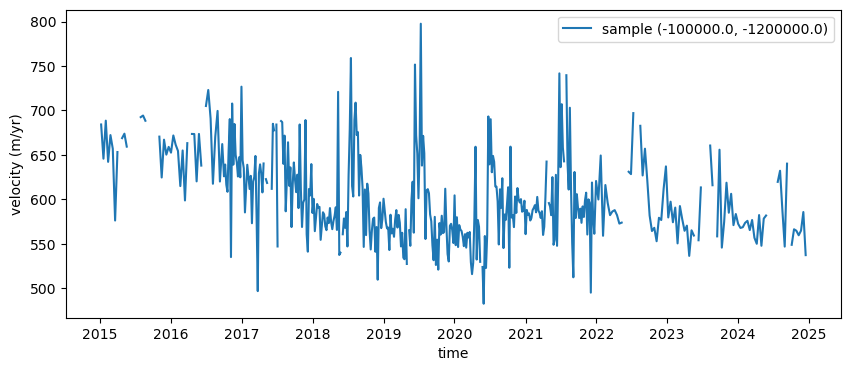

In [ ]:
x0 = -100000.0
y0 = -1200000.0

label = 'sample'

vv_band = velocity["VelocityMap"].sel(band='vv')

vel_sample_pt = vv_band.sel(x=x0, y=y0, method='nearest')
df_selected_point = vel_sample_pt.to_dataframe().reset_index()

plt.figure(figsize=(10,4))
plt.plot(df_selected_point['time'], df_selected_point['VelocityMap'], label=f'{label} ({x0}, {y0})')
plt.xlabel('time')
plt.ylabel('velocity (m/yr)')
plt.legend()
plt.show()

#should clean this? claire has a notebook on this 
#should also find a way to pick a point near the terminsu 
# no needto interpooalte

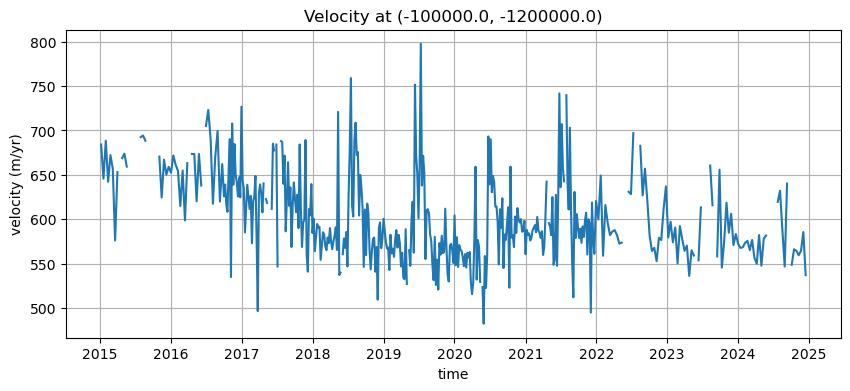

In [ ]:

#random upstream point 
sample1 = vv.sel(x=-170000, y=-2200000, method="nearest")  # DataArray with time dim
df_sample = sample1.to_dataframe().reset_index()

plt.figure(figsize=(10,4))
plt.plot(df_sample["time"], df_sample["VelocityMap"])
plt.xlabel("time")
plt.ylabel("velocity (m/yr)")
plt.title(f"Velocity at ({x0}, {y0})")
plt.grid()
plt.show()



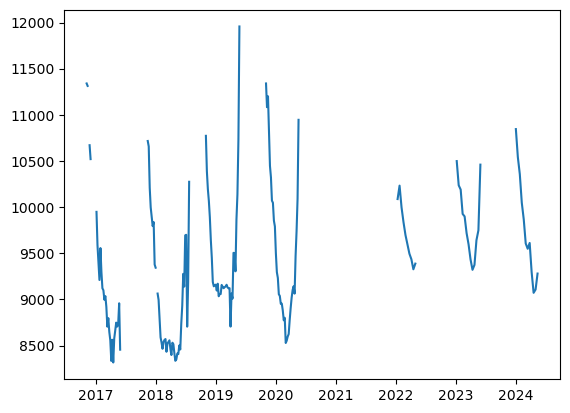

In [ ]:
#at date = 1
x_pt = df.loc[0, "x"]
y_pt = df.loc[0, "y"]

vel_pt = vv.sel(x=x_pt, y=y_pt, method="nearest")
df_vel = vel_pt.to_dataframe().reset_index()
plt.plot(df_vel["time"], df_vel["VelocityMap"])

In [ ]:
u_vals = []       # velocity at intersection (m/yr)

for _, row in df.iterrows():
    x = row["x"]
    y = row["y"]
    t = row["Date"]

    if pd.isna(x) or pd.isna(y) or pd.isna(t):
        u_vals.append(np.nan)
        continue

    v_intersect = vv.sel(time=t, x=x, y=y, method="nearest").values

    if np.isnan(v_intersect):
        u_vals.append(np.nan)
    else:
        u_vals.append(float(v_intersect))


df["u_per_yr"] = u_vals

In [ ]:
# assuming a veloicty of 1500 m/a to begin the calving series

u_constant = 1500.0 #unit is m /year 

df["u_per_year"] = u_constant


,Date,L,del_L,dt_days,dt_years,dL,dLdt_per_year,x,y,u_m_per_yr,calving_m_per_yr,u_per_year,calving,vel_date,vel_dt_days
0,2015-01-03,1492.80,NaN,NaN,NaN,NaN,NaN,-182302.342764,-2.275255e+06,NaN,NaN,1500.0,NaN,2015-01-06 12:00:00,3.5
1,2015-01-15,1036.50,-456.270,12.0,0.032854,-456.30,-13888.631250,-182654.615903,-2.274965e+06,NaN,NaN,1500.0,15388.631250,2015-01-18 12:00:00,3.5
2,2015-01-27,1112.70,76.181,12.0,0.032854,76.20,2319.337500,-182594.683736,-2.275012e+06,NaN,NaN,1500.0,-819.337500,2015-01-30 12:00:00,3.5
3,2015-02-08,790.49,-322.240,12.0,0.032854,-322.21,-9807.266875,-182850.185458,-2.274816e+06,NaN,NaN,1500.0,11307.266875,2015-02-11 12:00:00,3.5
4,2015-02-20,1937.40,1146.900,12.0,0.032854,1146.91,34909.073125,-181981.364513,-2.275562e+06,NaN,NaN,1500.0,-33409.073125,2015-02-23 12:00:00,3.5
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
241,2021-11-27,1394.10,-264.480,6.0,0.016427,-264.50,-16101.437500,-182377.541027,-2.275191e+06,NaN,NaN,1500.0,17601.437500,2021-11-27 12:00:00,0.5
242,2021-12-03,1204.90,-189.170,6.0,0.016427,-189.20,-11517.550000,-182522.167388,-2.275069e+06,NaN,NaN,1500.0,13017.550000,2021-12-03 12:00:00,0.5
243,2021-12-09,1446.70,241.830,6.0,0.016427,241.80,14719.575000,-182337.465762,-2.275225e+06,NaN,NaN,1500.0,-13219.575000,2021-12-09 12:00:00,0.5
244,2021-12-15,1280.10,-166.670,6.0,0.016427,-166.60,-10141.775000,-182464.396164,-2.275117e+06,NaN,NaN,1500.0,11641.775000,2021-12-15 12:00:00,0.5


In [ ]:
df["calving"] = df["u_per_year"] - df["dLdt_per_year"]

#calving unit is m /yr
# calving rate > 0 : terminus advance  (due to velocity)
# calving rate < 0 : terminus retreat (due to calving)

In [ ]:
df

,Date,L,del_L,dt_days,dt_years,dL,dLdt_per_year,x,y,u_m_per_yr,calving_m_per_yr,u_per_year,calving
0,2015-01-03,1492.80,NaN,NaN,NaN,NaN,NaN,-182302.342764,-2.275255e+06,NaN,NaN,1500.0,NaN
1,2015-01-15,1036.50,-456.270,12.0,0.032854,-456.30,-13888.631250,-182654.615903,-2.274965e+06,NaN,NaN,1500.0,15388.631250
2,2015-01-27,1112.70,76.181,12.0,0.032854,76.20,2319.337500,-182594.683736,-2.275012e+06,NaN,NaN,1500.0,-819.337500
3,2015-02-08,790.49,-322.240,12.0,0.032854,-322.21,-9807.266875,-182850.185458,-2.274816e+06,NaN,NaN,1500.0,11307.266875
4,2015-02-20,1937.40,1146.900,12.0,0.032854,1146.91,34909.073125,-181981.364513,-2.275562e+06,NaN,NaN,1500.0,-33409.073125
...,...,...,...,...,...,...,...,...,...,...,...,...,...
241,2021-11-27,1394.10,-264.480,6.0,0.016427,-264.50,-16101.437500,-182377.541027,-2.275191e+06,NaN,NaN,1500.0,17601.437500
242,2021-12-03,1204.90,-189.170,6.0,0.016427,-189.20,-11517.550000,-182522.167388,-2.275069e+06,NaN,NaN,1500.0,13017.550000
243,2021-12-09,1446.70,241.830,6.0,0.016427,241.80,14719.575000,-182337.465762,-2.275225e+06,NaN,NaN,1500.0,-13219.575000
244,2021-12-15,1280.10,-166.670,6.0,0.016427,-166.60,-10141.775000,-182464.396164,-2.275117e+06,NaN,NaN,1500.0,11641.775000


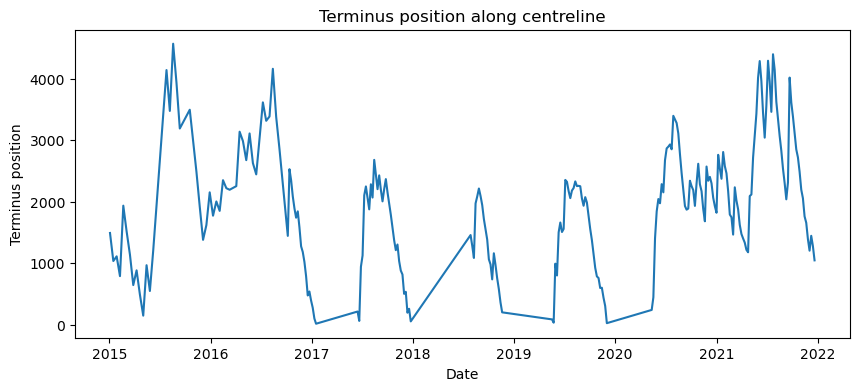

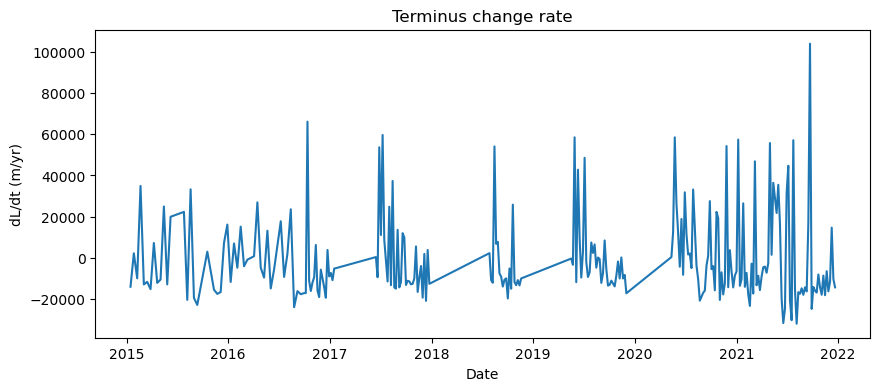

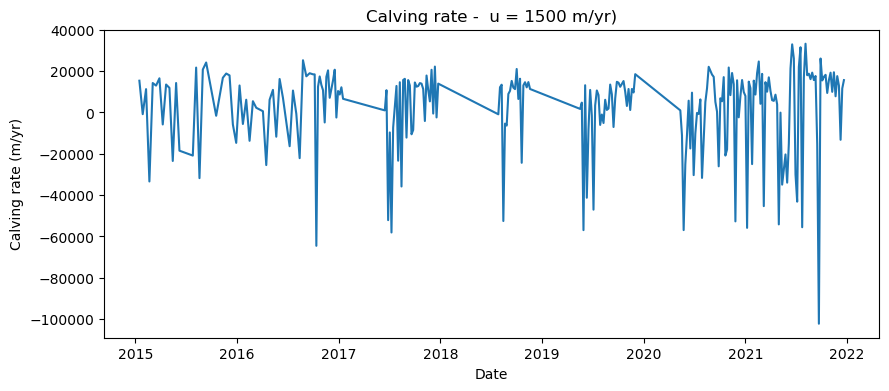

In [ ]:

plt.figure(figsize=(10,4))
plt.plot(df["Date"], df["L"])
plt.xlabel("Date")
plt.ylabel("Terminus position")
plt.title("Terminus position along centreline")
plt.show()

plt.figure(figsize=(10,4))
plt.plot(df["Date"], df["dLdt_per_year"])
plt.xlabel("Date")
plt.ylabel("dL/dt (m/yr)")
plt.title("Terminus change rate")
plt.show()

plt.figure(figsize=(10,4))
plt.plot(df["Date"], df["calving"])
plt.xlabel("Date")
plt.ylabel("Calving rate (m/yr)")
plt.title("Calving rate -  u = 1500 m/yr)")
plt.show()

To do:
- comment/mark down
- reformatfigures into 2x1 
- check that the non nan values nearest x0 and y0 value are actually close to the values
- to change to magnitude multiply